In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.utils import save_image

C:\conda\envs\pt2303cpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 设置参数

In [3]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batchsize = 4

## 准备数据

In [4]:
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [6]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
        
    # print(old_data.classes)
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [7]:
normal_data = image_folder_custom_label(root = './data/imagenet', transform = transform, custom_label = idx2label)

normal_loader = Data.DataLoader(normal_data, batch_size=batchsize, shuffle=False)

In [8]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


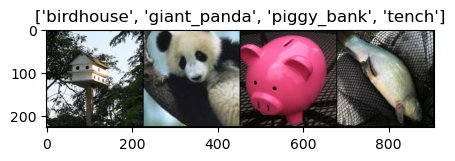

In [9]:
# 显示原始图像及真实标签
normal_iter = iter(normal_loader)
images, labels = normal_iter.__next__()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 加载模型

In [10]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))

    def forward(self, input):
        # Broadcasting
        # input = input / 255.0
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return ((input - mean) / std)

In [11]:
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# inputs: [b, 3, 224, 224];[0,255]
model = nn.Sequential(
    norm_layer,
    models.resnet50(pretrained=True)
).to(device)

C:\conda\envs\pt2303cpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\conda\envs\pt2303cpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True Image & Predicted Label


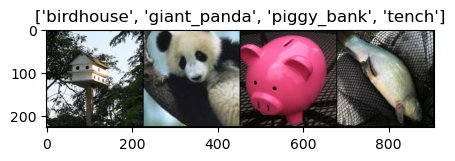

Accuracy of test: 100.000000 %


In [12]:
# 显示原始图像及模型预测标签
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test: %f %%' % (100 * float(correct) / (total*batchsize)))

## 注意力图

In [13]:
from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

In [14]:
def genecam(images, labels, cam_extractor, savepath=None):
    # input: images(torch, [B, C, W, H])
    # output: attention map(torch) tensor
    
    outs = model(images)
    class_idx = labels.tolist()
    cams = cam_extractor(class_idx, outs)[0]  # ??
    return cams

def cam2mask(cams, size):
    # input: cams
    # size: tuple, size of image
    rel = torchvision.transforms.functional.resize(cams, size,interpolation=torchvision.transforms.InterpolationMode.BICUBIC) # 默认为BILINEAR
    return torch.clamp(rel,min=0.)

In [15]:
cam_extractor = SmoothGradCAMpp(model)

## 随机采样

In [16]:
def rdmasksPoi(gmask, numsam):
    # input: gmask [B, H, W]; numsam: number of samples (with replace)
    gmask=gmask.float()
    count = 0
    maxeachb = (gmask.max(axis=1).values).max(axis=1).values
    sumeachb = (gmask.sum(axis=1)).sum(axis=1)
    
    B=gmask.shape[0]
    R=gmask.shape[1]
    C=gmask.shape[2]
    for i in range(B):
        gmask[i,:,:] = (1.0*gmask[i,:,:])/sumeachb[i].item()
    # print(gmask)
        
    result=torch.zeros(size=gmask.shape)
    proprob = torch.rand(numsam).sort().values
    mu = numsam*gmask
    
    # print(mu)
    
    result = torch.poisson(mu)
    
    result=result.unsqueeze(1).repeat((1,3,1,1))
    return (result>0).float()

In [17]:
# 生成注意力图
for images, labels in normal_loader:
    cams = genecam(images, labels, cam_extractor)
    masks = cam2mask(cams,(224,224))

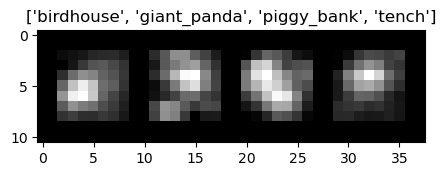

In [18]:
imshow(torchvision.utils.make_grid(cams.unsqueeze(1).repeat((1,3,1,1)), normalize=True), [normal_data.classes[i] for i in labels])

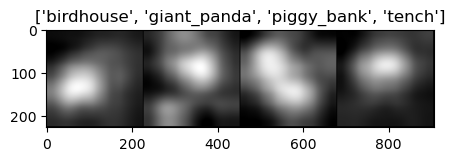

In [19]:
imshow(torchvision.utils.make_grid(masks.unsqueeze(1), normalize=True), [normal_data.classes[i] for i in labels])

tensor(216543.)


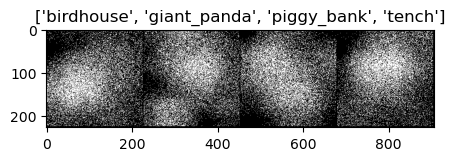

In [20]:
# 采样示例
numsam=25000
rdmask = rdmasksPoi(masks, numsam)
rdmask = (rdmask>0).float()
print(rdmask.sum())
imshow(torchvision.utils.make_grid(rdmask, normalize=True), [normal_data.classes[i] for i in labels])

## 对抗攻击

In [21]:
# perc: 更改的比例[1,100]
def pgd_attack(model, images, labels, numsam=25000, eps=0.3, alpha=2/255, iters=40) :
    
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        print("iter:{}".format(i))
        
        rdmask = rdmasksPoi(masks, numsam)
        
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()
        
        
        
        adv_images = images + rdmask*alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

Attack Image & Predicted Label
iter:0
iter:1
iter:2
iter:3
iter:4
iter:5
iter:6
iter:7
iter:8
iter:9


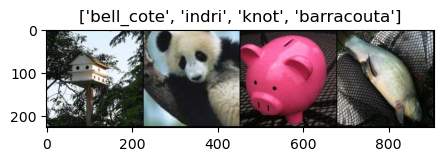

Accuracy of test text: 0.000000 %


In [22]:
print("Attack Image & Predicted Label")
model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = pgd_attack(model, images, labels,iters=10, numsam=10000)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / (total*batchsize)))